#Mount google drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Download the dataset

In [ ]:
import os
import urllib.request

url = "https://nrvis.com/download/data/asn/mammalia-dolphin-florida-overall.zip"
dataset_zip = "mammalia-dolphin-florida-overall.zip"
filename = "mammalia-dolphin-florida-overall.edges"
output_dir = "/content/drive/MyDrive/GraphLA/clustering"
data_dir = "/content/drive/MyDrive/GraphLA/data"

os.makedirs(output_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

if not os.path.exists(dataset_zip):
    print(f"Downloading {dataset_zip}...")
    try:
        urllib.request.urlretrieve(url, dataset_zip)
        print("Download completed!")
    except Exception as e:
        print(f"Error during download: {e}")

Download completed!


#Unzip the dataset

In [ ]:
import zipfile

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
  zip_ref.extractall('.')

#Define some utility method

In [ ]:
import pickle
import random
import sys
from os import path
from matplotlib import pyplot as plt

import networkx as nx
import torch

def draw_communities(G, cluster_info, save=True):
    fig, ax = plt.subplots(figsize=(12, 10))

    num_clusters = len(cluster_info)
    cmap = plt.colormaps["tab20"].resampled(num_clusters)

    pos = nx.spring_layout(G, seed=42)

    for i, c in enumerate(cluster_info):
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=c["followers"],
            node_size=300,
            node_color=[cmap(i)] * len(c["followers"]),
            alpha=0.85,
            ax=ax
        )

    leaders = [c["leader"] for c in cluster_info]
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=leaders,
        node_size=800,
        node_color="gold",
        edgecolors="red",
        linewidths=2.5,
        ax=ax
    )

    nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    ax.set_title("Cluster")
    ax.axis("off")
    fig.tight_layout()

    if save:
        fig.savefig(os.path.join(output_dir, "clustering.png"), dpi=300, bbox_inches='tight')

    plt.show()

def load_graph(file_path: str) -> nx.Graph:
    if not path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    G = nx.Graph()
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            u, v = parts[0], parts[1]
            w = float(parts[2])
            G.add_edge(u, v, weight=w)

    return G


#Main

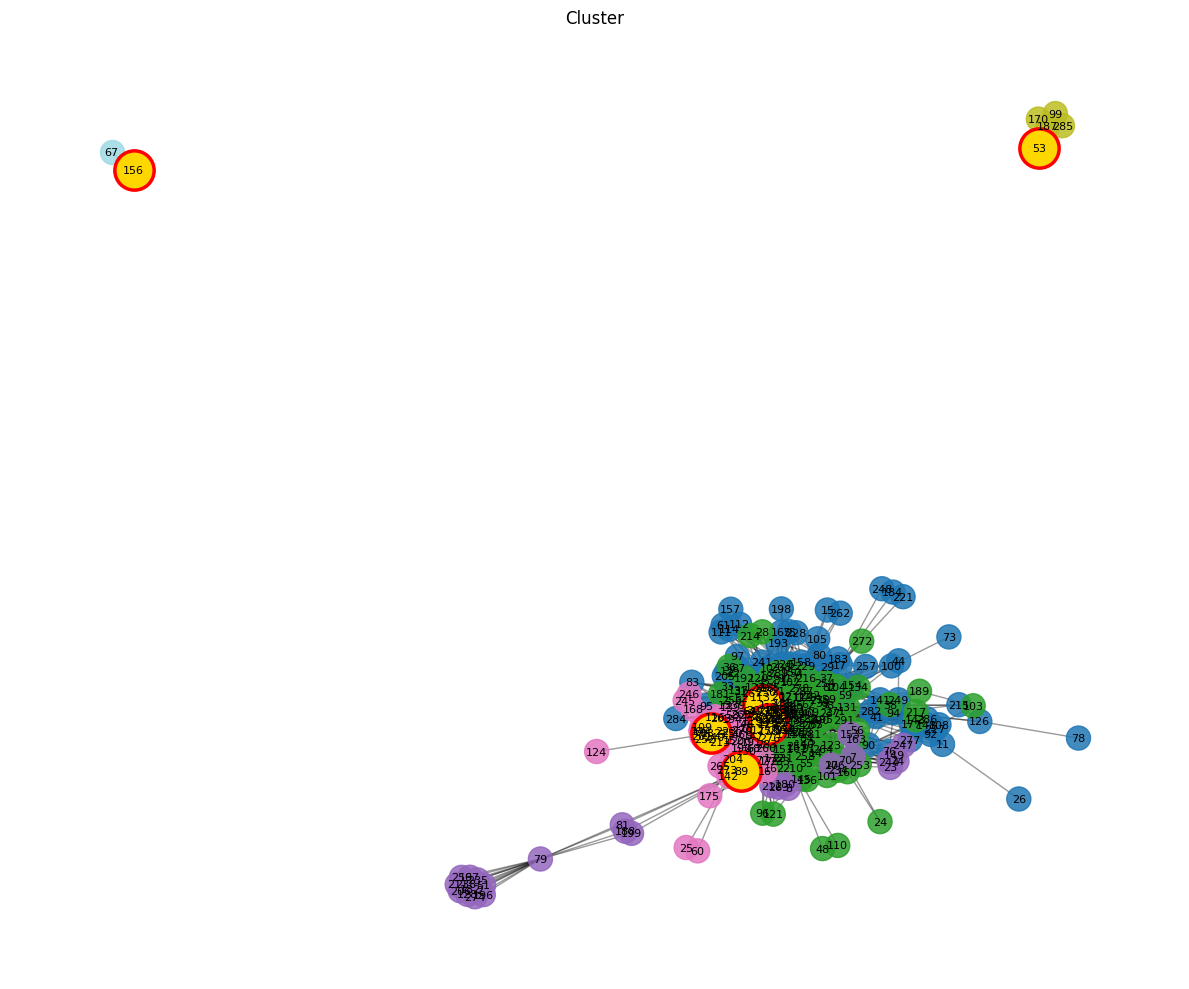

Saving clusters information...
Clusters information saved successfully


In [ ]:
import pickle

import networkx as nx

# 1) Load the graph
G = load_graph(filename)

# 2) Clustering
cluster = nx.algorithms.community.louvain.louvain_communities(
     G, weight='weight', resolution=0.45, threshold=1e-07, seed=42
)

cluster_info = []
for i, comm in enumerate(cluster, start=1):
    leader = min(
        comm,
        key=lambda n: sum(
            nx.single_source_dijkstra_path_length(G, n, weight="weight").get(t, float('inf'))
            for t in comm
        )
    )

    followers = [n for n in comm if n != leader]

    cluster_info.append({
        "id": i,
        "leader": leader,
        "followers": followers,
    })

# 3) Show plot
draw_communities(G, cluster_info)

# 4) Save the cluster data
print("Saving clusters information...")

try:
    with open(os.path.join(data_dir,'cluster_info.pkl'), "wb") as f:
        pickle.dump(cluster_info, f)

except (OSError, IOError) as e:
    print(f"Some error occur: {e}")
else:
    print("Clusters information saved successfully")